In [1]:
DATA_CSV = "../results/strong_basins.csv"

GENERATE_DATA = False
# Parameters for generating data
MODEL_DIRECTORY = "../models/random_nk3"
UPDATE = "asynchronous"
N_RANDOM = 30 # number of random models
DEBUG = False
NSQUARE_STEPS = 20 # number of steps for nsquare

# Figure configuration
MAIN_FIGURE_ID = "4"
SUP_FIGURE_ID = "s2"
METRICS = ["recall", "npv"]
METHODS = None # plot all methods
FIGURE_DIR = "../results/figures"

In [2]:
import pandas as pd
from pyboolnet.external.bnet2primes import bnet_text2primes
from pyboolnet.prime_implicants import percolate
from pyboolnet.file_exchange import primes2bnet
from pyboolnet.state_transition_graphs import primes2stg
from IPython.display import display

import sdmarkov.plotting.config as pc
from sdmarkov.transition_matrix import get_transition_matrix, get_uniform_matrix
from sdmarkov.matrix_operations import nsquare, compress_matrix, expand_matrix, get_confusion_matrix
from sdmarkov.basins import get_convergence_matrix, get_strong_basins
from sdmarkov.grouping import sd_grouping, null_grouping, random_grouping
from sdmarkov.attractors import get_predicted_attractors
from sdmarkov.analysis.utils import load_or_generate_data, add_classification_metrics, network_level_metrics_df
from sdmarkov.plotting.figures import plot_violin_figure, plot_distribution_figure, save_figure

## Data generation or loading

In [3]:
def get_data_strong_basins(
    bnet,
    bnet_name=None,
    update="asynchronous",
    num_runs=30,
    DEBUG=False,
):

    rows = []

    primes = bnet_text2primes(bnet)
    primes = {key: primes[key] for key in sorted(primes)}

    # Percolate constant nodes
    percolated_primes = percolate(primes, remove_constants=True, copy=True)
    if len(percolated_primes) == 0:
        return pd.DataFrame(rows)

    percolated_bnet = primes2bnet(percolated_primes)
    n_states = 2 ** len(percolated_primes)
    stg = primes2stg(percolated_primes, update)

    # Full transition matrix
    T = get_transition_matrix(stg, DEBUG=DEBUG)

    # grouped transition matrices
    sd_indices = sd_grouping(percolated_bnet, DEBUG=DEBUG)
    Tsd = compress_matrix(T, sd_indices, DEBUG=DEBUG)

    null_indices = null_grouping(percolated_bnet, DEBUG=DEBUG)
    Tnull = compress_matrix(T, null_indices, DEBUG=DEBUG)

    # Predicted attractors
    predicted_attractor_indices = get_predicted_attractors(Tsd, sd_indices, as_indices=True, DEBUG=DEBUG)
    n_attractors = len(predicted_attractor_indices)

    if n_attractors < 2:
        return pd.DataFrame(rows)

    # actual strong basins
    T_inf = nsquare(T, NSQUARE_STEPS, DEBUG=DEBUG)
    convergence = get_convergence_matrix(T_inf, predicted_attractor_indices, DEBUG=DEBUG)
    strong_basins = get_strong_basins(convergence, DEBUG=DEBUG)

    # reference
    uniform_convergence = get_uniform_matrix(n_states, n_attractors)
    ref_strong_basins = get_strong_basins(uniform_convergence, DEBUG=DEBUG)

    # grouped strong basins
    def grouped_strong_basins(T_grouped, indices, predicted_attractors, DEBUG=False):
        T_grouped_inf = nsquare(T_grouped, NSQUARE_STEPS, DEBUG=DEBUG)
        T_grouped_inf_expanded = expand_matrix(T_grouped_inf, indices, DEBUG=DEBUG)
        convergence_matrix = get_convergence_matrix(T_grouped_inf_expanded,predicted_attractors,DEBUG=DEBUG)
        return get_strong_basins(convergence_matrix, DEBUG=DEBUG)

    sd_strong_basins = grouped_strong_basins(Tsd, sd_indices, predicted_attractor_indices, DEBUG=DEBUG)
    null_strong_basins = grouped_strong_basins(Tnull, null_indices, predicted_attractor_indices, DEBUG=DEBUG)

    # Find TP, FP, TN, FN and add to rows
    def add_row(method, predictions, run=None):
        TP, FP, TN, FN = get_confusion_matrix(strong_basins, predictions, partial=True, DEBUG=DEBUG)
        rows.append({
            "bnet": bnet_name,
            "method": method,
            "run": run,
            "TP": TP,
            "FP": FP,
            "TN": TN,
            "FN": FN,
            "n_states": n_states,
            "n_attractors": n_attractors,
        })

    add_row("sd_mc", sd_strong_basins)
    add_row("null_mc", null_strong_basins)
    add_row("ref", ref_strong_basins)

    for i in range(num_runs):
        random_indices = random_grouping(sd_indices, null_indices, seed=i, DEBUG=DEBUG)
        Trandom = compress_matrix(T, random_indices, DEBUG=DEBUG)
        
        random_strong_basins = grouped_strong_basins(Trandom, random_indices, predicted_attractor_indices, DEBUG=DEBUG)
        
        add_row("random_mc", random_strong_basins, run=i)

    return pd.DataFrame(rows)

In [4]:
df = load_or_generate_data(
    data_csv=DATA_CSV,
    generate_data=GENERATE_DATA,
    data_function=get_data_strong_basins,
    model_directory=MODEL_DIRECTORY,
    update=UPDATE,
    n_random=N_RANDOM,
    debug=DEBUG,
)

Loaded cached results from ../results/strong_basins.csv.


In [5]:
print("Preview of results DataFrame:")
display(df.head())

print("\nDataFrame shape:", df.shape)
print("Methods present:", df.method.unique())
print("Number of unique networks:", df.bnet.nunique())

Preview of results DataFrame:


,bnet,method,run,TP,FP,TN,FN,n_states,n_attractors,update_scheme
0,n010_000.bnet,sd_mc,NaN,640,0,384,0,1024,2,asynchronous
1,n010_000.bnet,null_mc,NaN,64,0,384,576,1024,2,asynchronous
2,n010_000.bnet,ref,NaN,0,0,384,640,1024,2,asynchronous
3,n010_000.bnet,random_mc,0.0,64,0,384,576,1024,2,asynchronous
4,n010_000.bnet,random_mc,1.0,64,0,384,576,1024,2,asynchronous



DataFrame shape: (1518, 10)
Methods present: ['sd_mc' 'null_mc' 'ref' 'random_mc']
Number of unique networks: 46


## Data analysis

In [6]:
# filter out networks with a single attractor
df_multi = df[df["n_attractors"] > 1].copy()

# add precision, recall, specificity, and NPV
df_multi = add_classification_metrics(df_multi)

print("\nAdded classification metrics")
print("DataFrame shape:", df_multi.shape)
print("Methods present:", df_multi.method.unique())
print("Number of unique networks:", df_multi.bnet.nunique())


display(df_multi.head())


Added classification metrics
DataFrame shape: (1518, 14)
Methods present: ['sd_mc' 'null_mc' 'ref' 'random_mc']
Number of unique networks: 46


,bnet,method,run,TP,FP,TN,FN,n_states,n_attractors,update_scheme,precision,recall,specificity,npv
0,n010_000.bnet,sd_mc,NaN,640,0,384,0,1024,2,asynchronous,1.0,1.0,1.0,1.000
1,n010_000.bnet,null_mc,NaN,64,0,384,576,1024,2,asynchronous,1.0,0.1,1.0,0.400
2,n010_000.bnet,ref,NaN,0,0,384,640,1024,2,asynchronous,NaN,0.0,1.0,0.375
3,n010_000.bnet,random_mc,0.0,64,0,384,576,1024,2,asynchronous,1.0,0.1,1.0,0.400
4,n010_000.bnet,random_mc,1.0,64,0,384,576,1024,2,asynchronous,1.0,0.1,1.0,0.400


In [7]:
df_metrics = network_level_metrics_df(df=df_multi)

print("Preview of network-level metrics DataFrame:")
display(df_metrics.head())

print("\nDataFrame shape:", df_metrics.shape)
print("Methods present:", df_metrics.method.unique())
print("Number of unique networks:", df_metrics.bnet.nunique())

print("\nNetwork-level classification metrics:")
metrics = ["precision", "recall", "specificity", "npv"]
summary = (
    df_metrics
    .groupby("method")[metrics]
    .agg(["mean", "min", "median", "max"])
)

display(summary)

Preview of network-level metrics DataFrame:


,bnet,method,TP,FP,TN,FN,n_states,n_attractors,update_scheme,precision,recall,specificity,npv
0,n010_000.bnet,null_mc,64.0,0.0,384.0,576.0,1024.0,2.0,asynchronous,1.0,0.100000,1.0,0.40000
1,n010_000.bnet,random_mc,64.0,0.0,384.0,576.0,1024.0,2.0,asynchronous,1.0,0.100000,1.0,0.40000
2,n010_000.bnet,ref,0.0,0.0,384.0,640.0,1024.0,2.0,asynchronous,NaN,0.000000,1.0,0.37500
3,n010_000.bnet,sd_mc,640.0,0.0,384.0,0.0,1024.0,2.0,asynchronous,1.0,1.000000,1.0,1.00000
4,n010_001.bnet,null_mc,6.0,0.0,36.0,22.0,64.0,5.0,asynchronous,1.0,0.214286,1.0,0.62069



DataFrame shape: (184, 13)
Methods present: ['null_mc' 'random_mc' 'ref' 'sd_mc']
Number of unique networks: 46

Network-level classification metrics:


precision                     recall                           \
               mean  min median  max      mean       min    median  max   
method                                                                    
null_mc         1.0  1.0    1.0  1.0  0.297157  0.005102  0.196154  1.0   
random_mc       1.0  1.0    1.0  1.0  0.300963  0.005102  0.196154  1.0   
ref             NaN  NaN    NaN  NaN  0.000000  0.000000  0.000000  0.0   
sd_mc           1.0  1.0    1.0  1.0  0.855849  0.040816  1.000000  1.0   

          specificity                        npv                                
                 mean  min median  max      mean       min    median       max  
method                                                                          
null_mc           1.0  1.0    1.0  1.0  0.582380  0.000000  0.618037  1.000000  
random_mc         1.0  1.0    1.0  1.0  0.583576  0.000000  0.631211  1.000000  
ref               1.0  1.0    1.0  1.0  0.478133  0.000000  0.482422  0.976562  
sd_mc             1.0  1.0    1.0  1.0  0.930838  0.483871  0.981456  1.000000

## Plotting

In [8]:
pc.apply_style()

INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


PosixPath('../results/figures/Figure_4_Strong_basins.png')

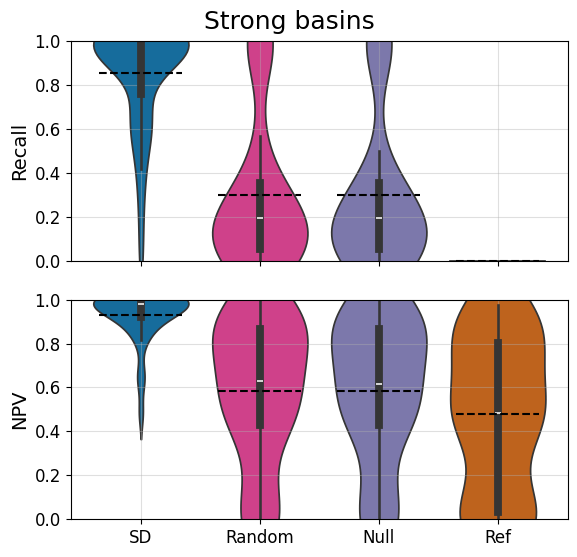

In [9]:
fig1 = plot_violin_figure(df_metrics, metrics=METRICS, figure_id=MAIN_FIGURE_ID)

save_figure(fig1, figure_id=MAIN_FIGURE_ID, outdir=FIGURE_DIR)

/home/troonmel/SDMarkov/sdmarkov/src/sdmarkov/plotting/figures.py:176: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


PosixPath('../results/figures/Figure_s2_Strong_basins.png')

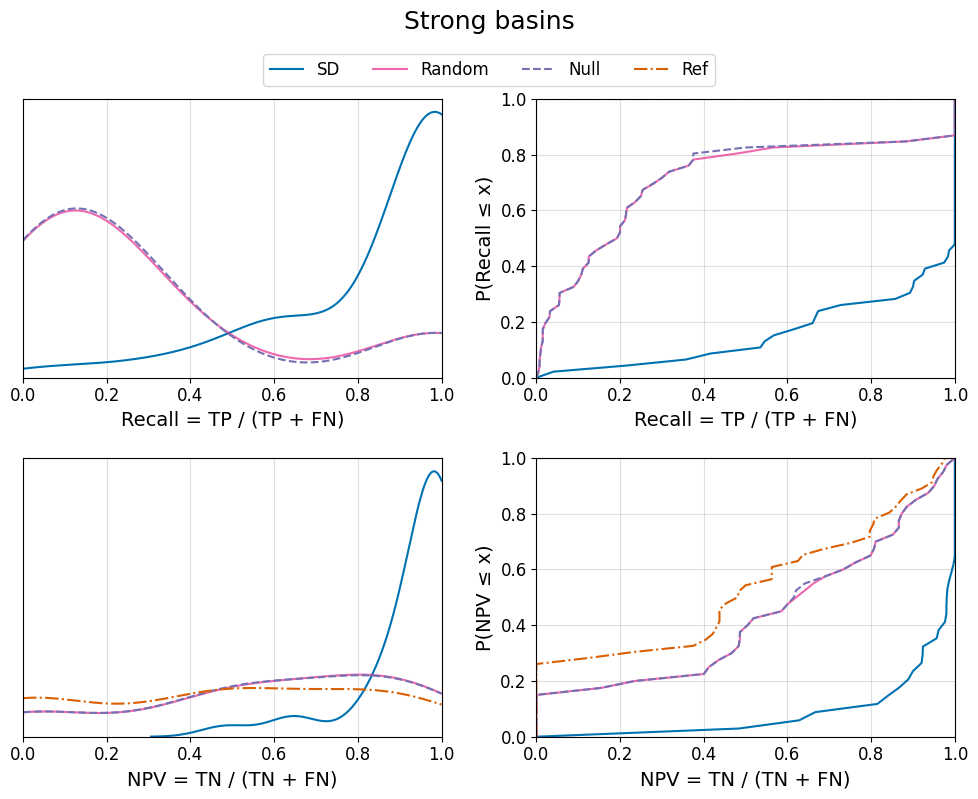

In [10]:
fig2 = plot_distribution_figure(df_metrics, metrics=METRICS, figure_id=SUP_FIGURE_ID)

save_figure(fig2, figure_id=SUP_FIGURE_ID, outdir=FIGURE_DIR)